Copyright (c) Meta Platforms, Inc. and affiliates.
This software may be used and distributed according to the terms of the Llama 2 Community License Agreement.

<a href="https://colab.research.google.com/github/meta-llama/llama-recipes/blob/main/recipes/quickstart/finetuning/quickstart_peft_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PEFT Finetuning Quick Start Notebook

This notebook shows how to train a Meta Llama 3 model on a single GPU (e.g. A10 with 24GB) using int8 quantization and LoRA finetuning.

**_Note:_** To run this notebook on a machine with less than 24GB VRAM (e.g. T4 with 16GB) the context length of the training dataset needs to be adapted.
We do this based on the available VRAM during execution.
If you run into OOM issues try to further lower the value of train_config.context_length.

# v3

바뀐점
- 전처리 과정에 \n\n\n 이렇게 연속된 개행문자가 들어간 경우 \n 하나로 바꾸도록 만듬.
- hyperparameter 수정. 
  - gradient_accumulation_steps = 4
  - num_epochs = 2
  - context_length = 512
- 입력 형식에서 plot_parameter 제거

In [1]:
# conda create -n ladlm_v1 python=3.11
# !conda install -y pytorch torchvision torchaudio pytorch-cuda=12.4 -c pytorch -c nvidia

In [2]:
# uncomment if running from Colab T4
# ! pip install llama-recipes ipywidgets

In [3]:
# !pip install huggingface_hub

In [4]:
from huggingface_hub import login
# login() 

### Step 1: Load the model

Setup training configuration and load the model and tokenizer.

In [5]:
import torch
from transformers import MllamaForConditionalGeneration, AutoTokenizer, AutoProcessor
from llama_recipes.configs import train_config as TRAIN_CONFIG

train_config = TRAIN_CONFIG()
train_config.model_name = "meta-llama/Llama-3.2-11B-Vision-Instruct"
train_config.num_epochs = 2
train_config.run_validation = False
train_config.gradient_accumulation_steps = 4
train_config.batch_size_training = 1
train_config.lr = 3e-4
train_config.use_fast_kernels = True
train_config.use_fp16 = True
train_config.context_length = 512 if torch.cuda.get_device_properties(0).total_memory < 16e9 else 1024 # T4 16GB or A10 24GB
train_config.batching_strategy = "packing"
train_config.output_dir = "ladlm_v3"
train_config.use_peft = True

from transformers import BitsAndBytesConfig
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16
)


model = MllamaForConditionalGeneration.from_pretrained(
            train_config.model_name,
            quantization_config=bnb_config,
            device_map="auto",
            torch_dtype=torch.float16,
        )
processor = AutoProcessor.from_pretrained(train_config.model_name)

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

### Step 2: Check base model

Run the base model on an example input:

We can see that the base model only repeats the conversation.

### Step 3: Load the preprocessed dataset

We load and preprocess the samsum dataset which consists of curated pairs of dialogs and their summarization:

In [6]:
import copy
import itertools
from datasets import load_from_disk, Dataset
from PIL import Image
import torch
from torch.utils.data import DataLoader
import numpy as np
import os

# Assuming you have a processor compatible with Llama 3.2 Vision
# Replace `YourProcessor` with the actual processor class you're using

# Helper Functions
def check_header(targets, seq):
    """
    Check if any 3-token sequence in `seq` matches any target in `targets`.
    """
    for i in range(len(seq) - 2):
        if seq[i:i + 3] in targets:
            return True
    return False

def replace_target(target, seq):
    """
    Replace occurrences of `target` in `seq` with -100.
    """
    for i in range(len(seq) - 2):
        if seq[i:i + 3] == target:
            seq[i], seq[i + 1], seq[i + 2] = -100, -100, -100
    return seq

def tokenize_dialogs(dialogs, images, processor):
    """
    Tokenize the dialogs and images using the provided processor.
    Masks certain tokens as specified.
    """
    text_prompt = processor.apply_chat_template(dialogs)
    batch = processor(
        images=images,
        text=text_prompt,
        padding=True,
        return_tensors="pt"
    )
    label_list = []
    for i in range(len(batch["input_ids"])):
        dialog_tokens = batch["input_ids"][i].tolist()
        labels = copy.copy(dialog_tokens)
        eot_indices = [idx for idx, n in enumerate(labels) if n == 128009]
        last_idx = 0
        # Define prompt header sequences
        prompt_header_seqs = [
            [128006, 9125, 128007],  # <|start_header_id|>system<|end_header_id|>
            [128006, 882, 128007]    # <|start_header_id|>user<|end_header_id|>
        ]
        for idx in eot_indices:
            current_seq = labels[last_idx:idx + 1]
            if check_header(prompt_header_seqs, current_seq):
                # Mask the prompt header sequence
                labels[last_idx:idx + 1] = [-100] * (idx - last_idx + 1)
            else:
                last_idx = idx + 1
        # Mask assistant header prompt <|start_header_id|>assistant<|end_header_id|>
        assistant_header_seq = [128006, 78191, 128007]
        labels = replace_target(assistant_header_seq, labels)
        # Mask padding tokens and image tokens (128256)
        labels = [
            -100 if (token == processor.tokenizer.pad_token_id or token == 128256) else token
            for token in labels
        ]
        label_list.append(labels)
    batch["labels"] = torch.tensor(label_list)
    return batch

# Custom Dataset Loading Function
def get_custom_dataset(dataset_config, processor, split='train', split_ratio=0.9):
    """
    Load and preprocess the custom dataset.
    """
    # Replace with the actual path or identifier of your dataset
    dataset_path = '../../datasets/ladlm_dataset'  # Adjust this path if your dataset is saved elsewhere
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"The dataset at '{dataset_path}' does not exist.")

    dataset = load_from_disk(dataset_path)
    # dataset = dataset_dict['train']

    # Optionally select a subset for quick testing
    # Remove or adjust the following line to use the full dataset
    # dataset = dataset.select(range(200))  # Example: select first 200 samples

    # Split the dataset
    train_test_split = dataset.train_test_split(test_size=1 - split_ratio, shuffle=True, seed=42)
    return train_test_split[split]

# Custom Data Collator
class CustomDataCollator:
    def __init__(self, processor):
        self.processor = processor
        self.processor.tokenizer.padding_side = "right"  # Ensure padding on the right

    def __call__(self, samples):
        dialogs, images = [], []
        for sample in samples:
            file_name = sample['file_name']

            # Extract and convert images
            linear_spectrogram_with_axes_image = sample['linear_spectrogram_with_axes']['image'].convert("RGB") # we can use this?
            linear_spectrogram_no_axes_image = sample['linear_spectrogram_no_axes']['image'].convert("RGB")
            
            # Optionally, choose which spectrogram to use
            image = linear_spectrogram_no_axes_image

            # Extract parameters
            librosa_parameters = sample['linear_spectrogram_no_axes']['librosa_parameters']
            
            # Extract other features
            explanation_about_spectrogram = sample['explanation_about_spectrogram']

            # Replace multiple newlines with a single newline
            # explanation_about_spectrogram = re.sub(r'\n+', '\n', explanation_about_spectrogram)

            # Create dialogs as per your specification
            dialog = [
                {
                    "role": "user",
                    "content": [
                        {"type": "image"},
                        {"type": "text",
                         "text": f"This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. "
                                 f"The parameters used to extract this image are as follows: {librosa_parameters}. "
                                 f"\nExplanation about spectrogram:\n"}
                ]},
                {
                    "role": "assistant",
                    "content": [
                        {"type": "text", "text": explanation_about_spectrogram}
                    ]
                }
            ]
            dialogs.append(dialog)  # Each sample has a list of dialog lists
            images.append([image])     # Processor expects a list of image lists

        # Tokenize the dialogs and images
        batch = tokenize_dialogs(dialogs, images, self.processor)
        return batch

# Function to Get Data Collator
def get_data_collator(processor):
    return CustomDataCollator(processor)



In [12]:
import re

def preprocess_dataset(dataset):
    """
    텍스트 필드에서 연속된 개행 문자를 단일 개행 문자로 변경.
    이미지 데이터는 수정하지 않음.
    """
    for sample in dataset:
        if 'explanation_about_spectrogram' in sample:
            sample['explanation_about_spectrogram'] = re.sub(r'\n+', '\n', sample['explanation_about_spectrogram'])
    return dataset


In [13]:
from torch.utils.data import DataLoader

# Train/Test 데이터셋 로드
train_dataset = get_custom_dataset(
    dataset_config=None,
    processor=processor,
    split="train",
    split_ratio=0.9
)

eval_dataset = get_custom_dataset(
    dataset_config=None,
    processor=processor,
    split="test",
    split_ratio=0.9
)

train_dataset = preprocess_dataset(train_dataset)
eval_dataset = preprocess_dataset(eval_dataset)
 
# Data Collator 생성
data_collator = get_data_collator(processor)

# DataLoader 생성
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=train_config.batch_size_training, 
    collate_fn=data_collator, 
    shuffle=True
)

eval_dataloader = DataLoader(
    eval_dataset, 
    batch_size=train_config.batch_size_training, 
    collate_fn=data_collator, 
    shuffle=False
)

print(f"Train DataLoader and Eval DataLoader ready!")



Train DataLoader and Eval DataLoader ready!


In [9]:
# !pip install librosa

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def inference_vllm(sample, max_token=512):
    # 첫 번째 샘플의 이미지와 텍스트 추출
    file_name = sample['file_name']

    linear_spectrogram_with_axes_image = sample['linear_spectrogram_with_axes']['image'].convert("RGB")
    linear_spectrogram_no_axes_image = sample['linear_spectrogram_no_axes']['image'].convert("RGB")

    librosa_parameters = sample['linear_spectrogram_no_axes']['librosa_parameters']
    plot_parameters = sample['linear_spectrogram_no_axes']['plot_parameters']

    domain = sample['domain']              
    type = sample['type']                  
    machineType = sample['machineType']    
    explanation_about_spectrogram = sample['explanation_about_spectrogram']


    messages = [
        [
            {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text",
                    "text": f"This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. "
                            f"The parameters used to extract this image are as follows: {librosa_parameters}. "
                            f"\nExplanation about spectrogram:\n"}
            ]},
        ]
    ]

    input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(
        linear_spectrogram_no_axes_image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt"
    ).to(model.device)

    # # 입력을 모델이 있는 디바이스로 이동
    # inputs = {key: value.to(model.device) for key, value in inputs.items()}

    # 인퍼런스 수행
    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=max_token)

    print(processor.decode(output[0]))
    plt.imshow(linear_spectrogram_with_axes_image)
    plt.axis('off')
    plt.show()

    return processor.decode(output[0])


<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The provided image is a spectrogram, which is a visual representation of the frequency content of a signal over time. The spectrogram is created using the Short-Time Fourier Transform (STFT) with librosa, a Python library for audio signal processing.

**STFT Parameters**

The parameters used to extract the spectrogram are:

*   **n_fft**: 256, which specifies the size of the FFT window. In this case, the window size is 256 samples.
*   **hop_length**: 256, which specifies the hop length between consecutive frames. The hop length determines the overlap between frames, with a smaller hop length resulting in more frames and a larger hop len

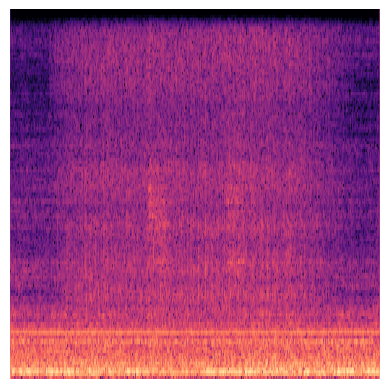

"<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. \nExplanation about spectrogram:\n<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nThe provided image is a spectrogram, which is a visual representation of the frequency content of a signal over time. The spectrogram is created using the Short-Time Fourier Transform (STFT) with librosa, a Python library for audio signal processing.\n\n**STFT Parameters**\n\nThe parameters used to extract the spectrogram are:\n\n*   **n_fft**: 256, which specifies the size of the FFT window. In this case, the window size is 256 samples.\n*   **hop_length**: 256, which specifies the hop length between consecutive frames. The hop length determines the overlap between frames, with a smaller hop length resulting in more frames and a 

In [15]:

inference_vllm(train_dataset[0])


### Step 4: Prepare model for PEFT

Let's prepare the model for Parameter Efficient Fine Tuning (PEFT):

In [16]:
from peft import get_peft_model, prepare_model_for_kbit_training, LoraConfig
from dataclasses import asdict
from llama_recipes.configs import lora_config as LORA_CONFIG

lora_config = LORA_CONFIG()
lora_config.r = 8
lora_config.lora_alpha = 32
lora_dropout: float=0.02

peft_config = LoraConfig(**asdict(lora_config))

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

### Step 5: Fine tune the model

Here, we fine tune the model for a single epoch.

In [17]:
import torch.optim as optim
from llama_recipes.utils.train_utils import train
from torch.optim.lr_scheduler import StepLR

model.train()

optimizer = optim.AdamW(
            model.parameters(),
            lr=train_config.lr,
            weight_decay=train_config.weight_decay,
        )
scheduler = StepLR(optimizer, step_size=1, gamma=train_config.gamma)

# Start the training process
results = train(
    model,
    train_dataloader,
    eval_dataloader,
    processor, # tokenizor 대채
    optimizer,
    scheduler,
    train_config.gradient_accumulation_steps,
    train_config,
    None,
    None,
    None,
    wandb_run=None,
)

/home/uturtle/anaconda3/envs/llama_recipe_vision/lib/python3.11/site-packages/llama_recipes/model_checkpointing/checkpoint_handler.py:17: DeprecationWarning: `torch.distributed._shard.checkpoint` will be deprecated, use `torch.distributed.checkpoint` instead
  from torch.distributed._shard.checkpoint import (
/home/uturtle/anaconda3/envs/llama_recipe_vision/lib/python3.11/site-packages/llama_recipes/utils/train_utils.py:92: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/home/uturtle/anaconda3/envs/llama_recipe_vision/lib/python3.11/site-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


Starting epoch 0/2
train_config.max_train_step: 0


Training Epoch: 1:   0%|          | 0/67 [00:00<?, ?it/s]/home/uturtle/anaconda3/envs/llama_recipe_vision/lib/python3.11/site-packages/llama_recipes/utils/train_utils.py:152: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/home/uturtle/anaconda3/envs/llama_recipe_vision/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/uturtle/anaconda3/envs/llama_recipe_vision/lib/python3.11/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradien

Max CUDA memory allocated was 11 GB
Max CUDA memory reserved was 12 GB
Peak active CUDA memory was 11 GB
CUDA Malloc retries : 3
CPU Total Peak Memory consumed during the train (max): 4 GB
Epoch 1: train_perplexity=1.4925, train_epoch_loss=0.4005, epoch time 301.69554055000117s
Starting epoch 1/2
train_config.max_train_step: 0


Training Epoch: 2/2, step 270/271 completed (loss: 0.24147658050060272): : 68it [04:56,  4.37s/it]                     4.39s/it] 

Max CUDA memory allocated was 11 GB
Max CUDA memory reserved was 11 GB
Peak active CUDA memory was 11 GB
CUDA Malloc retries : 4
CPU Total Peak Memory consumed during the train (max): 4 GB
Epoch 2: train_perplexity=1.2973, train_epoch_loss=0.2603, epoch time 297.22286770199935s


### Step 6:
Save model checkpoint

In [18]:
model.save_pretrained(train_config.output_dir)

### Step 7:
Try the fine tuned model on the same example again to see the learning progress:

In [19]:
import torch
from PIL import Image

# 모델을 평가 모드로 전환
model.eval()


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MllamaForConditionalGeneration(
      (vision_model): MllamaVisionModel(
        (patch_embedding): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14), padding=valid, bias=False)
        (gated_positional_embedding): MllamaPrecomputedPositionEmbedding(
          (tile_embedding): Embedding(9, 8197120)
        )
        (pre_tile_positional_embedding): MllamaPrecomputedAspectRatioEmbedding(
          (embedding): Embedding(9, 5120)
        )
        (post_tile_positional_embedding): MllamaPrecomputedAspectRatioEmbedding(
          (embedding): Embedding(9, 5120)
        )
        (layernorm_pre): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (layernorm_post): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (transformer): MllamaVisionEncoder(
          (layers): ModuleList(
            (0-31): 32 x MllamaVisionEncoderLayer(
              (self_attn): MllamaVisionSdpaAttention(
               

<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

In the 4s-8s range, there is a strong energy distribution across the entire bandwidth, which sounds reminiscent of wind (or bat wing flapping).<|eot_id|>


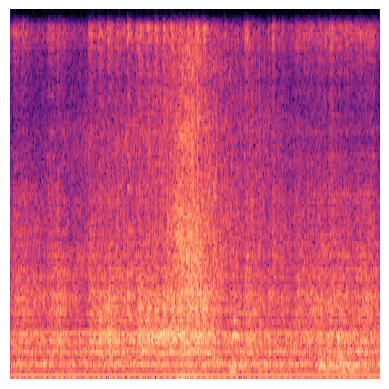

<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The text translates to:

"In the 4s-8s range, there is a strong energy distribution across the entire bandwidth, resembling the sound of wind (or bat wings). In the 4s-5.5s range, there is a strong energy distribution in the 6-8 kHz bandwidth, which sounds like a burst of quality aching mid-frequency. Additionally, in the 4s-5.5s range, there is a strong energy distribution in the 4-6 kHz bandwidth, which sounds like a burst of quality aching mid-frequency."<|eot_id|>


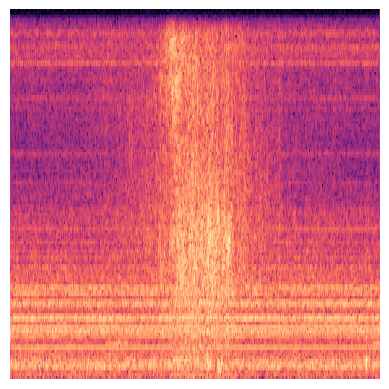

<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Strong energy is observed at low frequencies (0 kHz - 1 kHz). At high frequencies, the intensity is very weak for one second in both directions. The horizontal linear pattern of weak intensity appears at 1 kHz and 0.5 kHz.<|eot_id|>


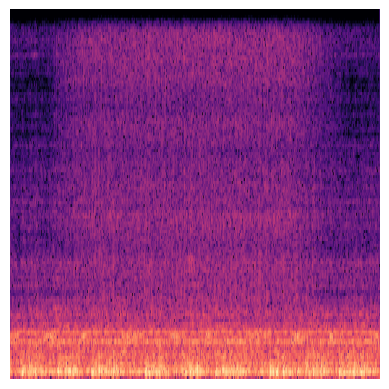

In [20]:
from PIL import Image
import matplotlib.pyplot as plt

for i in range(3):
    inference_vllm(eval_dataset[i])

### Step 8 make compare table


<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Strong energy at low frequencies (0 kHz - 1 kHz). The intensity of the mid-frequency is very weak for 1 second before and after. In the high mid-frequency range (5 kHz - 6 kHz), a weak, non-periodic pattern of increased intensity is observed.<|eot_id|>


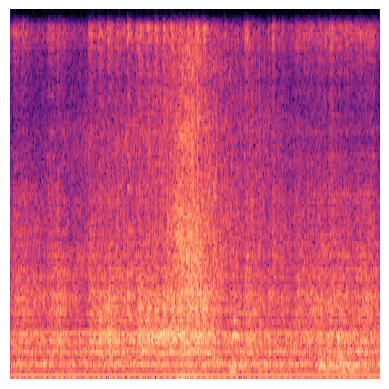

recreated: Strong energy at low frequencies (0 kHz - 1 kHz). The intensity of the mid-frequency is very weak for 1 second before and after. In the high mid-frequency range (5 kHz - 6 kHz), a weak, non-periodic pattern of increased intensity is observed.<|eot_id|>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Strong energy at low frequencies (0 kHz - 1 kHz). The intensity is very weak one second before and after at high frequencies. A vertical linear pattern is observed where the frequency of the entire band strengthens at intervals of 0.1 seconds.<|eot_id|>


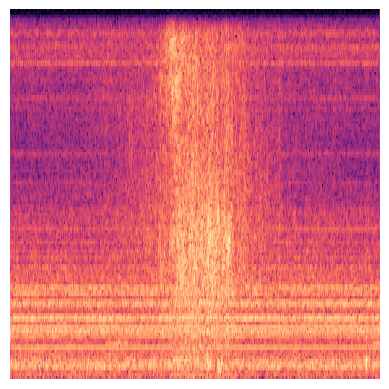

recreated: Strong energy at low frequencies (0 kHz - 1 kHz). The intensity is very weak one second before and after at high frequencies. A vertical linear pattern is observed where the frequency of the entire band strengthens at intervals of 0.1 seconds.<|eot_id|>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Strong energy in the low-frequency range (0 kHz - 1 kHz). The intensity is very weak one second before and after in the high-frequency range. In the mid-frequency range (5 kHz - 7 kHz), there is a weak energy distribution that resembles the sound of wind (or the fluttering of bat wings).<|eot_id|>


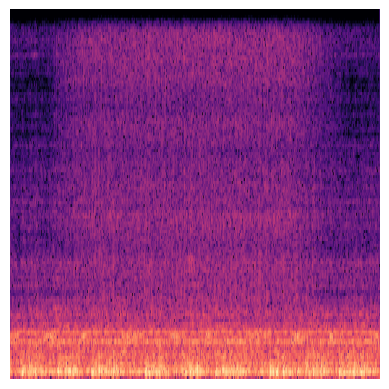

recreated: Strong energy in the low-frequency range (0 kHz - 1 kHz). The intensity is very weak one second before and after in the high-frequency range. In the mid-frequency range (5 kHz - 7 kHz), there is a weak energy distribution that resembles the sound of wind (or the fluttering of bat wings).<|eot_id|>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Strong energy is observed at low frequencies (0 kHz - 1 kHz). The intensity at high frequencies is very weak in the one-second intervals before and after. A weak, non-periodic pattern of increased intensity is observed at low mid-frequencies (2 kHz - 3 kHz). Additionally, a non-periodic pattern of increased intensity is observed at h

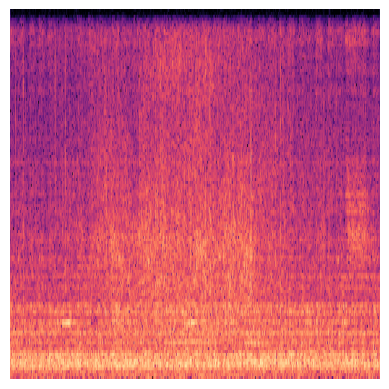

recreated: Strong energy is observed at low frequencies (0 kHz - 1 kHz). The intensity at high frequencies is very weak in the one-second intervals before and after. A weak, non-periodic pattern of increased intensity is observed at low mid-frequencies (2 kHz - 3 kHz). Additionally, a non-periodic pattern of increased intensity is observed at high mid-frequencies (5 kHz - 6 kHz).<|eot_id|>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Strong energy at low frequencies (0 kHz - 1 kHz).  
The intensity at high frequencies is very weak in the 1-second interval before and after.  
A horizontal linear pattern appears at 0.2 kHz, 1 kHz, and 1.5 kHz.<|eot_id|>


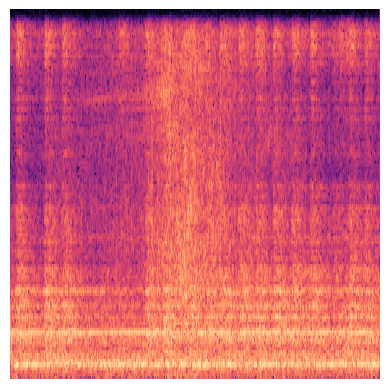

recreated: Strong energy at low frequencies (0 kHz - 1 kHz).  
The intensity at high frequencies is very weak in the 1-second interval before and after.  
A horizontal linear pattern appears at 0.2 kHz, 1 kHz, and 1.5 kHz.<|eot_id|>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Strong energy in the low frequency range (0 kHz - 1 kHz). In the high frequency range, the intensity is weak for one second before and after. A horizontal linear pattern appears at 0.2 kHz and 1 kHz.<|eot_id|>


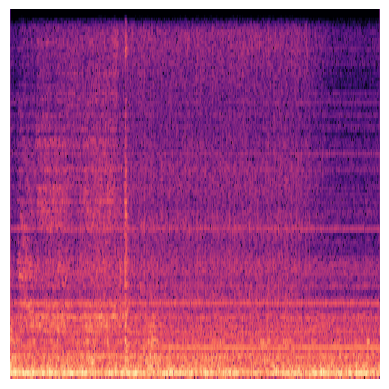

recreated: Strong energy in the low frequency range (0 kHz - 1 kHz). In the high frequency range, the intensity is weak for one second before and after. A horizontal linear pattern appears at 0.2 kHz and 1 kHz.<|eot_id|>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Strong energy at low frequencies (0 kHz - 1 kHz). The intensity at high frequencies is very weak, with a reduction of 1 second in both directions. There is a weak, non-periodic pattern of spikes that exists from low to mid frequencies.<|eot_id|>


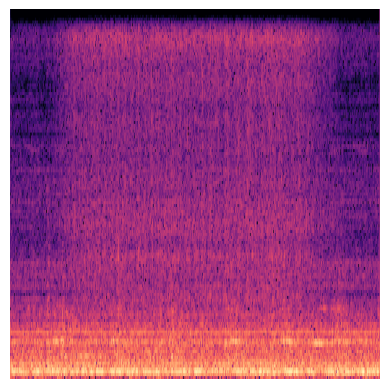

recreated: Strong energy at low frequencies (0 kHz - 1 kHz). The intensity at high frequencies is very weak, with a reduction of 1 second in both directions. There is a weak, non-periodic pattern of spikes that exists from low to mid frequencies.<|eot_id|>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Strong energy is observed at 6 seconds, with a gradual decrease in intensity over a period of 1 second. This is followed by a weak, intermittent pattern of spikes that persists for 0.5 seconds, centered around the 6-second mark.<|eot_id|>


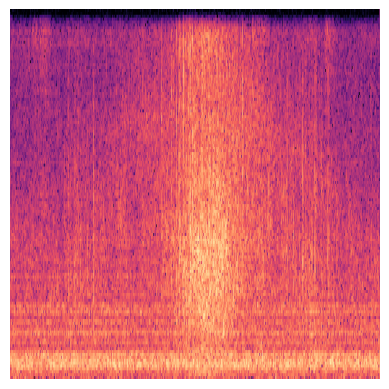

recreated: Strong energy is observed at 6 seconds, with a gradual decrease in intensity over a period of 1 second. This is followed by a weak, intermittent pattern of spikes that persists for 0.5 seconds, centered around the 6-second mark.<|eot_id|>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Strong energy at low frequencies (0 kHz - 1 kHz). The intensity of high frequencies is weak for one second in both directions. There is a non-periodic pattern where the intensity of high frequencies increases for 0.5 seconds.<|eot_id|>


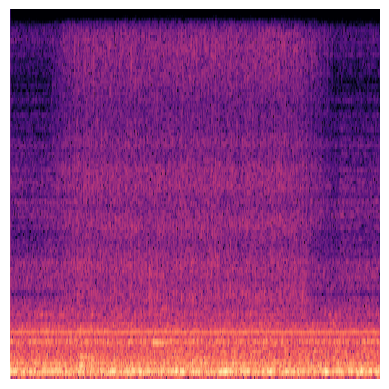

recreated: Strong energy at low frequencies (0 kHz - 1 kHz). The intensity of high frequencies is weak for one second in both directions. There is a non-periodic pattern where the intensity of high frequencies increases for 0.5 seconds.<|eot_id|>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The horizontal linear pattern is observed at 0.2 kHz and 1.3 kHz. There is a strong energy distribution across the entire frequency range from 4 seconds to 8 seconds, which resembles the sound of wind (or the flapping of bat wings). Additionally, there is a strong energy distribution across the entire frequency range from 6 seconds to 8 seconds, which sounds like a crackling noise.<|eot_id|>


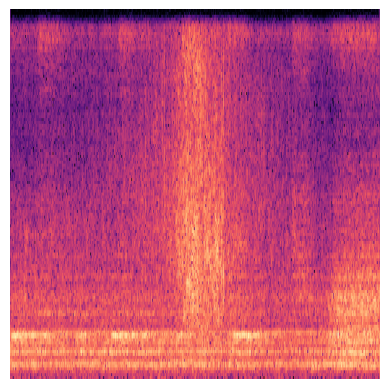

recreated: The horizontal linear pattern is observed at 0.2 kHz and 1.3 kHz. There is a strong energy distribution across the entire frequency range from 4 seconds to 8 seconds, which resembles the sound of wind (or the flapping of bat wings). Additionally, there is a strong energy distribution across the entire frequency range from 6 seconds to 8 seconds, which sounds like a crackling noise.<|eot_id|>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

A weak vertical linear pattern is observed, where the frequency of the entire band intensifies for a duration of 0.1 seconds, accompanied by a crackling sound. In the 4s-8s range, there is a strong energy distribution across the entire ban

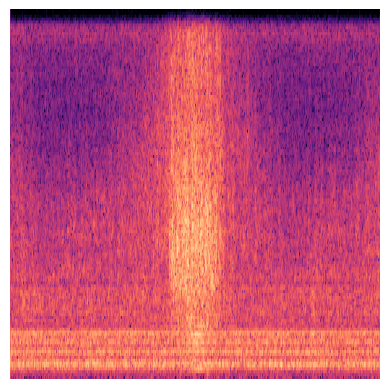

recreated: A weak vertical linear pattern is observed, where the frequency of the entire band intensifies for a duration of 0.1 seconds, accompanied by a crackling sound. In the 4s-8s range, there is a strong energy distribution across the entire band, which resembles the sound of wind (or the flapping of bat wings). A horizontal linear pattern is observed, where the frequency of the entire band intensifies for a duration of 0.1 seconds.<|eot_id|>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The distribution shows a gradual decrease in energy, resembling a hill formed around the 6-second mark. A strong energy distribution is observed across the entire 4-8-second interval, resemblin

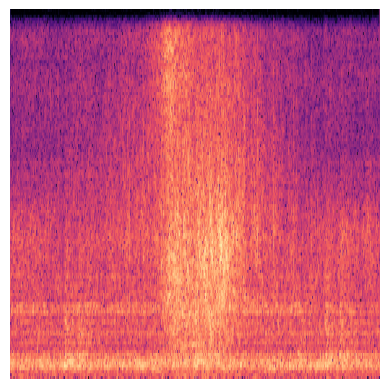

recreated: The distribution shows a gradual decrease in energy, resembling a hill formed around the 6-second mark. A strong energy distribution is observed across the entire 4-8-second interval, resembling the sound of wind (or bat wing flapping).<|eot_id|>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

In the 4s-8s interval, there is a strong energy distribution across the entire bandwidth, which sounds like a burst of sound. Additionally, in the 4s-5.5s range, a non-periodic pattern of weak intensity in the 6-8 kHz range is observed.<|eot_id|>


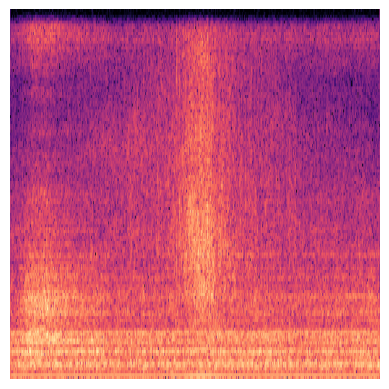

recreated: In the 4s-8s interval, there is a strong energy distribution across the entire bandwidth, which sounds like a burst of sound. Additionally, in the 4s-5.5s range, a non-periodic pattern of weak intensity in the 6-8 kHz range is observed.<|eot_id|>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Strong energy at low frequencies (0 kHz - 1 kHz). The intensity is very weak at high frequencies for 1 second before and after.<|eot_id|>


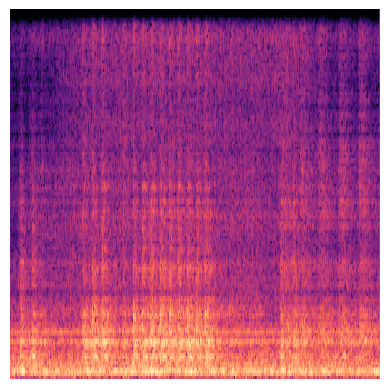

recreated: Strong energy at low frequencies (0 kHz - 1 kHz). The intensity is very weak at high frequencies for 1 second before and after.<|eot_id|>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

In the 4s-8s range, a medium energy distribution is observed, with the energy distribution gradually decreasing as the frequency increases. A strong energy distribution is noted in the 4s-5.5s interval at 6-8 kHz, which resembles the sound of wind (or bat wing flapping). A weak vertical linear pattern is present, which is periodically observed at intervals of 0.1s.<|eot_id|>


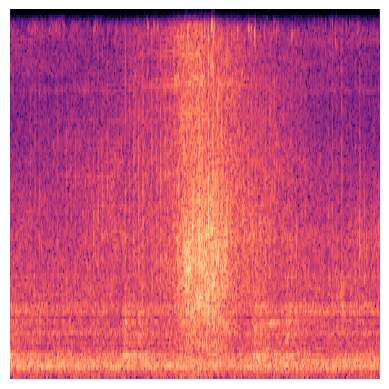

recreated: In the 4s-8s range, a medium energy distribution is observed, with the energy distribution gradually decreasing as the frequency increases. A strong energy distribution is noted in the 4s-5.5s interval at 6-8 kHz, which resembles the sound of wind (or bat wing flapping). A weak vertical linear pattern is present, which is periodically observed at intervals of 0.1s.<|eot_id|>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The distribution of energy exhibits a gradual decrease, with a strong energy distribution in the 4s-8s range resembling the sound of wind (or bat wing flapping). There is a weak, non-periodic vertical linear pattern in the 4s-8s range. Additionally, a weak

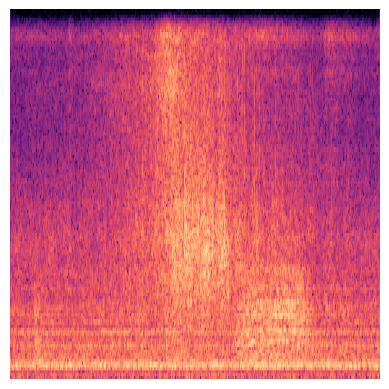

recreated: The distribution of energy exhibits a gradual decrease, with a strong energy distribution in the 4s-8s range resembling the sound of wind (or bat wing flapping). There is a weak, non-periodic vertical linear pattern in the 4s-8s range. Additionally, a weak, non-periodic vertical linear pattern is observed in the 0.2s-0.3s interval.<|eot_id|>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The horizontal linear pattern appears irregularly, with the intensity of the sound decreasing as the frequency increases. There is a strong energy distribution in the low-frequency range (0 kHz - 1 kHz). In the high-frequency range, the intensity decreases significantly over a 0.5-second i

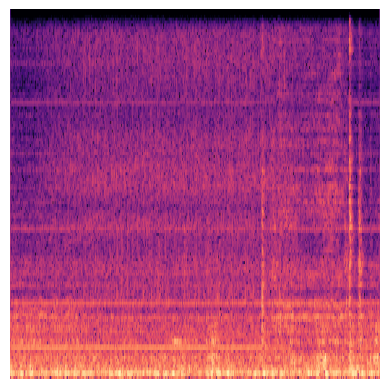

recreated: The horizontal linear pattern appears irregularly, with the intensity of the sound decreasing as the frequency increases. There is a strong energy distribution in the low-frequency range (0 kHz - 1 kHz). In the high-frequency range, the intensity decreases significantly over a 0.5-second interval. Additionally, there is a weak, non-periodic pattern of spikes that exists from low to mid frequencies.<|eot_id|>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Strong energy in the low-frequency range (0 kHz - 1 kHz). The intensity is very weak in the high-frequency range one second before and after.<|eot_id|>


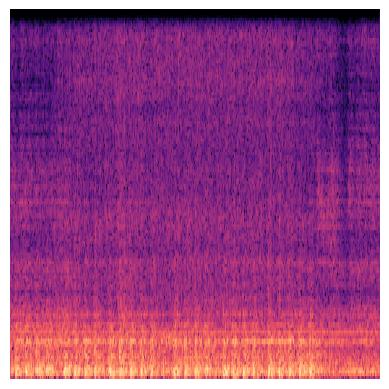

recreated: Strong energy in the low-frequency range (0 kHz - 1 kHz). The intensity is very weak in the high-frequency range one second before and after.<|eot_id|>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The intensity is weak for 1 second before and after.<|eot_id|>


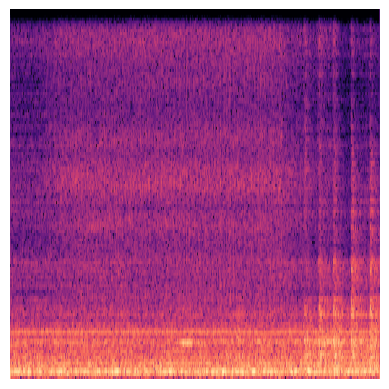

recreated: The intensity is weak for 1 second before and after.<|eot_id|>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Strong energy at low frequencies (0 kHz - 1 kHz). The intensity of the mid-frequency is weak for 1 second in both directions. A horizontal linear pattern appears at 0.2 kHz. There is a strong energy distribution across the entire band at the 6-second mark, resembling the sound of wind or bat wing flapping.<|eot_id|>


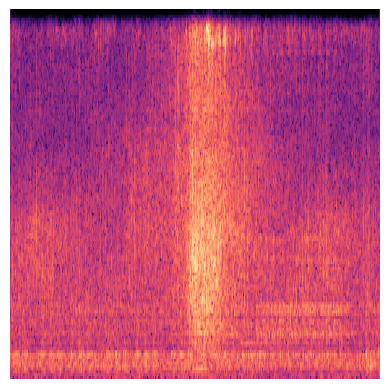

recreated: Strong energy at low frequencies (0 kHz - 1 kHz). The intensity of the mid-frequency is weak for 1 second in both directions. A horizontal linear pattern appears at 0.2 kHz. There is a strong energy distribution across the entire band at the 6-second mark, resembling the sound of wind or bat wing flapping.<|eot_id|>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Strong energy at low frequencies (0 kHz - 1 kHz). The intensity is very weak one second before and after at high frequencies.<|eot_id|>


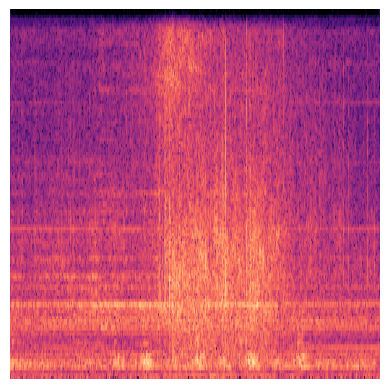

recreated: Strong energy at low frequencies (0 kHz - 1 kHz). The intensity is very weak one second before and after at high frequencies.<|eot_id|>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Strong energy in the low-frequency range (0 kHz - 1 kHz). The intensity in the high-frequency range is weak for one second before and after. A horizontal linear pattern appears at 0.2 kHz, 1 kHz, and 1.8 kHz.<|eot_id|>


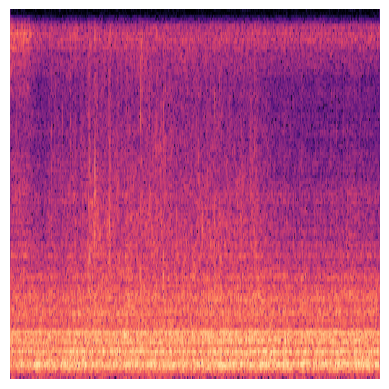

recreated: Strong energy in the low-frequency range (0 kHz - 1 kHz). The intensity in the high-frequency range is weak for one second before and after. A horizontal linear pattern appears at 0.2 kHz, 1 kHz, and 1.8 kHz.<|eot_id|>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

In the 4s-8s range, there is a strong energy distribution across the entire band, particularly within the 4s-5.5s interval, where the energy distribution is notably stronger in the 6-8 kHz range, resembling the sound of wind (or the flapping of bat wings).<|eot_id|>


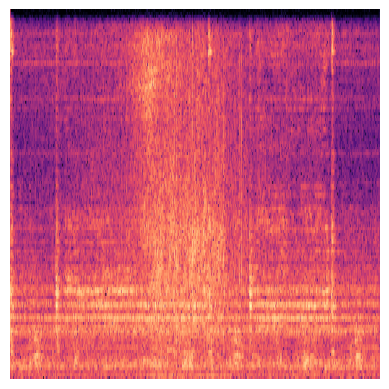

recreated: In the 4s-8s range, there is a strong energy distribution across the entire band, particularly within the 4s-5.5s interval, where the energy distribution is notably stronger in the 6-8 kHz range, resembling the sound of wind (or the flapping of bat wings).<|eot_id|>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Strong energy is observed in the 4s-8s range, which resembles the sound of wind (or the flapping of bat wings). A weak vertical linear pattern is observed around 6s, accompanied by a tapping sound.<|eot_id|>


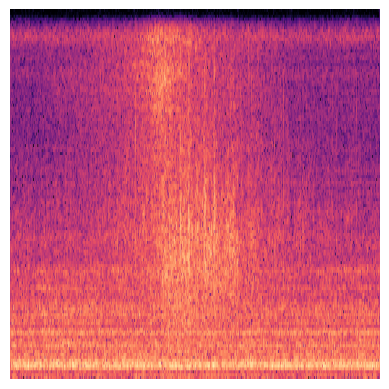

recreated: Strong energy is observed in the 4s-8s range, which resembles the sound of wind (or the flapping of bat wings). A weak vertical linear pattern is observed around 6s, accompanied by a tapping sound.<|eot_id|>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Strong energy is observed in the 4s-8s range, particularly in the 4s-5.5s interval, where there is a pronounced energy distribution across the entire frequency range, resembling the sound of wind (or bat wing flapping). Additionally, there is a strong energy distribution in the 6s-8s range, which sounds similar to a sharp tapping noise.<|eot_id|>


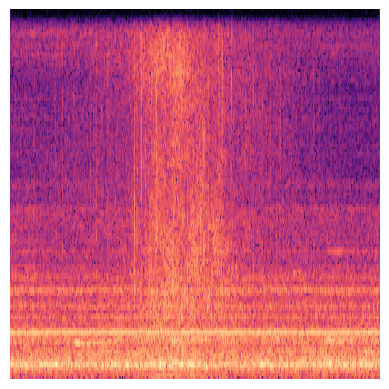

recreated: Strong energy is observed in the 4s-8s range, particularly in the 4s-5.5s interval, where there is a pronounced energy distribution across the entire frequency range, resembling the sound of wind (or bat wing flapping). Additionally, there is a strong energy distribution in the 6s-8s range, which sounds similar to a sharp tapping noise.<|eot_id|>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Strong energy at low frequencies (0 kHz - 1 kHz).  
At high frequencies (5 kHz - 6 kHz), a reduction in intensity is observed over a range of 1 kHz.  
A horizontal linear pattern is observed at 0.2 kHz.  
In the central interval, there is a strong energy distribution across the entire

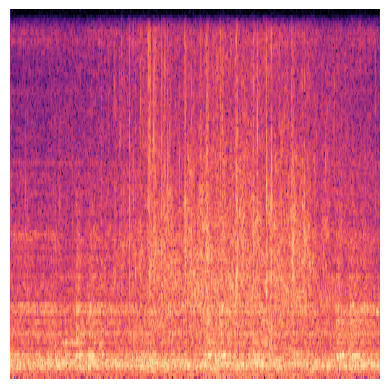

recreated: Strong energy at low frequencies (0 kHz - 1 kHz).  
At high frequencies (5 kHz - 6 kHz), a reduction in intensity is observed over a range of 1 kHz.  
A horizontal linear pattern is observed at 0.2 kHz.  
In the central interval, there is a strong energy distribution across the entire range, resembling the sound of wind or the fluttering of bat wings.<|eot_id|>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Strong energy at low frequencies (0 kHz - 1 kHz). The intensity at high frequencies is very weak for one second before and after.<|eot_id|>


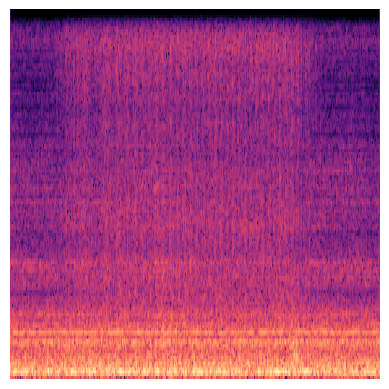

recreated: Strong energy at low frequencies (0 kHz - 1 kHz). The intensity at high frequencies is very weak for one second before and after.<|eot_id|>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Strong energy at low frequencies (0 kHz - 1 kHz). The intensity is very weak for one second before and after at high frequencies. There is a weak, non-periodic pattern of spikes in intensity that exists from low to mid frequencies.<|eot_id|>


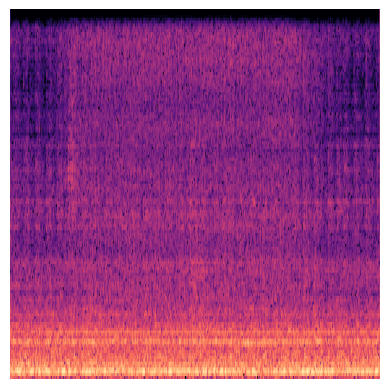

recreated: Strong energy at low frequencies (0 kHz - 1 kHz). The intensity is very weak for one second before and after at high frequencies. There is a weak, non-periodic pattern of spikes in intensity that exists from low to mid frequencies.<|eot_id|>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Strong energy at low frequencies (0 kHz - 1 kHz). The intensity at high frequencies is very weak, with a significant reduction in the one-second interval before and after.<|eot_id|>


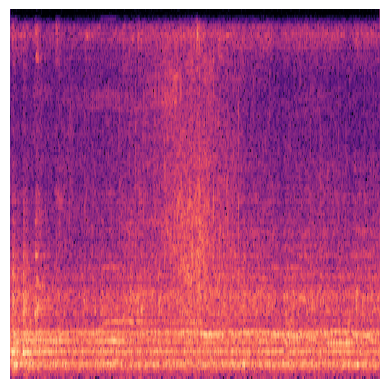

recreated: Strong energy at low frequencies (0 kHz - 1 kHz). The intensity at high frequencies is very weak, with a significant reduction in the one-second interval before and after.<|eot_id|>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Strong energy at low frequencies (0 kHz - 1 kHz). The intensity at high frequencies is very weak, with a duration of 1 second on both sides. A horizontal linear pattern is observed at 0.3 kHz. The intensity of the high mid-frequency range (5 kHz - 6 kHz) is slightly stronger than the surrounding frequencies. Additionally, the intensity of the low mid-frequency range (4 kHz - 5 kHz) is slightly stronger than the surrounding frequencies.<|eot_id|>


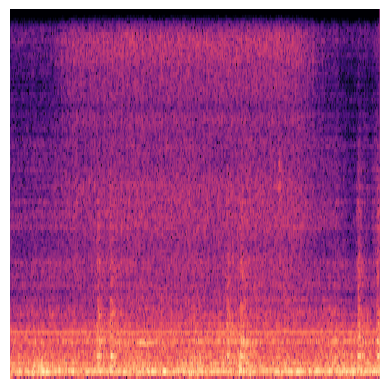

recreated: Strong energy at low frequencies (0 kHz - 1 kHz). The intensity at high frequencies is very weak, with a duration of 1 second on both sides. A horizontal linear pattern is observed at 0.3 kHz. The intensity of the high mid-frequency range (5 kHz - 6 kHz) is slightly stronger than the surrounding frequencies. Additionally, the intensity of the low mid-frequency range (4 kHz - 5 kHz) is slightly stronger than the surrounding frequencies.<|eot_id|>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. The parameters used to extract this image are as follows: {'n_fft': 256, 'hop_length': 256, 'window': 'hann'}. 
Explanation about spectrogram:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Strong energy at low frequencies (0 kHz - 1 kHz). The intensity is very weak in the 1-second intervals before and after at high frequencies. Additionally, there is a weak, non-periodic

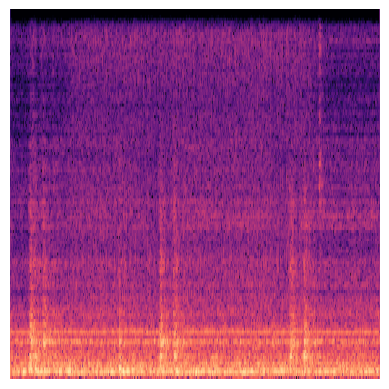

recreated: Strong energy at low frequencies (0 kHz - 1 kHz). The intensity is very weak in the 1-second intervals before and after at high frequencies. Additionally, there is a weak, non-periodic pattern in the form of spikes that exists from low frequencies to mid frequencies.<|eot_id|>
Evaluation results saved to ladlm_v3_evaluation_results.xlsx


In [21]:
import os
from PIL import Image as PILImage
from openpyxl import Workbook
from openpyxl.drawing.image import Image as ExcelImage
import matplotlib.pyplot as plt
import torch

# 엑셀 파일 생성
output_excel = f"{train_config.output_dir}_evaluation_results.xlsx"
wb = Workbook()
ws = wb.active
ws.title = "Evaluation Results"

# 열 헤더 설정
headers = [
    "File Name", "Domain", "Type", "Machine Type",
    "Explanation About Spectrogram", "Generated Text", "Spectrogram Image"
]
ws.append(headers)

# 평가 데이터셋 처리 루프
for i, sample in enumerate(eval_dataset):
    generated_text = inference_vllm(sample)

    if "<|start_header_id|>assistant<|end_header_id|>" in generated_text:
        generated_text = generated_text.split("<|start_header_id|>assistant<|end_header_id|>")[-1].strip()
    print(f"recreated: {generated_text}")

    file_name = sample['file_name']

    linear_spectrogram_with_axes_image = sample['linear_spectrogram_with_axes']['image'].convert("RGB")
    # linear_spectrogram_no_axes_image = sample['linear_spectrogram_no_axes']['image'].convert("RGB")

    # librosa_parameters = sample['linear_spectrogram_no_axes']['librosa_parameters']
    # plot_parameters = sample['linear_spectrogram_no_axes']['plot_parameters']

    domain = sample['domain']              
    type_ = sample['type']                  
    machineType = sample['machineType']    
    explanation_about_spectrogram = sample['explanation_about_spectrogram']

    # 플롯된 이미지 저장
    img_path = f"temp_image_{i}.png"
    plt.imshow(linear_spectrogram_with_axes_image)
    plt.axis('off')
    plt.savefig(img_path, bbox_inches='tight', pad_inches=0)
    plt.close()

    # 이미지 크기 확인
    with PILImage.open(img_path) as img:
        img_width, img_height = img.size

    # 엑셀 셀 크기 조정
    cell_width = img_width / 7  # 열 너비는 픽셀 크기의 1/7
    cell_height = img_height * 0.75  # 행 높이는 픽셀 크기의 0.75

    # 셀 크기 조정
    ws.column_dimensions['G'].width = max(ws.column_dimensions['G'].width or 0, cell_width)
    ws.row_dimensions[i + 2].height = cell_height

    # 엑셀에 데이터 추가
    ws.append([file_name, domain, type_, machineType, explanation_about_spectrogram, generated_text])

    # 이미지 삽입
    img = ExcelImage(img_path)
    img.anchor = f"G{i + 2}"  # 엑셀 셀 위치 지정 (헤더가 1줄 차지하므로 2부터 시작)
    ws.add_image(img)

# 엑셀 저장
wb.save(output_excel)

# 임시 이미지 파일 삭제
for i in range(len(eval_dataset)):
    img_path = f"temp_image_{i}.png"
    if os.path.exists(img_path):
        os.remove(img_path)

print(f"Evaluation results saved to {output_excel}")


### 추가할만한 부분?

- 현재 되는 부분

- 데이터셋은 대화라기 보다 분석이기 때문에 \n 로 끊기는 구간이 많다. 이것을 하나의 문장이나 문단으로 꾸미고 최종 결론까지 적어 dataset의 퀄리티를 향상시키면 좋겠다고 생각했다.
  - 현재 보면 단문으로 끊기는 문장이 생각보다 많다. 문장이 더 생성되지 않아 생기는 문제가 제일 크다는 점을 보아 데이터셋 output의 구체적인 foramt도 정해두는게 좋겠다 생각했다.
- spectrogram을 분석할때는 가로선형패턴과 spike, 그리고 어느 대역과 구간에 에너지 분포가 얼마나 강한지, 그리고 주기적인지 비주기적인지를 구체적으로 명시해야한다. 
  - 주제(가로선형 패턴 존재 위치, 스파이크 존재 여부, ) 별로 나누에서 있음 없음을 제대로 명시한다면 더 좋은 결과를 만들 것이다.
  - 특히 질문을 나누어서 학습시킨뒤 마지막에 최종 결론을 내리는 부분을 학습시킨다면 성능이 더 좋아질 수 있을 것이라 예측한다. 
    - 쉬운 문제에서 어려운 문제순으로 학습시키면 더욱 좋은 결과가 나온다: 
      - Reference
        - [A Survey of Large Language Models](https://arxiv.org/abs/2303.18223)
          - 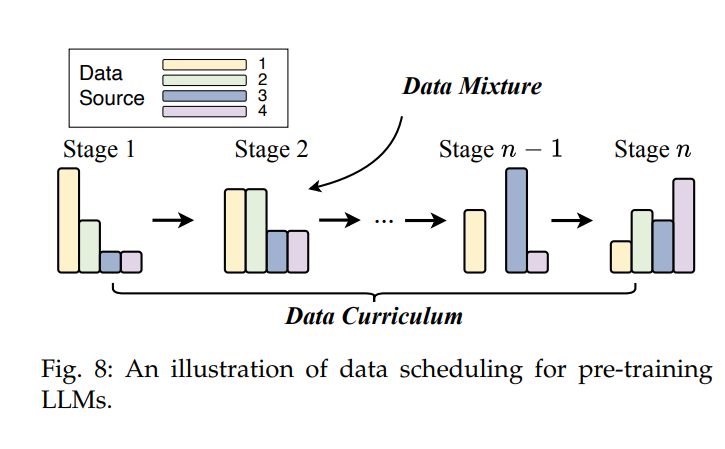
        - [Curriculum_learning](https://www.researchgate.net/publication/221344862_Curriculum_learning)

**현재 상황**?: 다른 다양한 데이터를 10~20개 정도만 제대로 학습시켜서 inference한다면 전체 데이터에 대한 eda가 훨씬 수월해질 수 있다는 가망성은 보인다. 하지만 아직 멀었다.